# I. Forecasting

## 1. Visualisation

In [115]:
sales_x = pd.DataFrame([1,2,3,4,5,6,7,8,9,10,11,12])
sales_y = pd.DataFrame([5384,8081,10282,9156,6118,9139,12460,10717,7825,9693,15177,10990])

In [116]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0, 0.5, 'Sales')

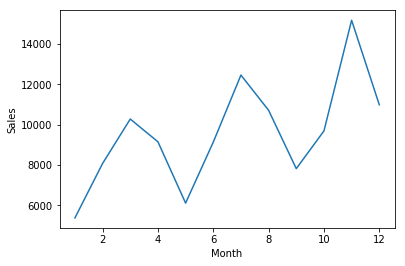

In [117]:
plt.plot(sales_x, sales_y)
plt.xlabel("Month")
plt.ylabel("Sales")

## 2. Prediction without seasonality

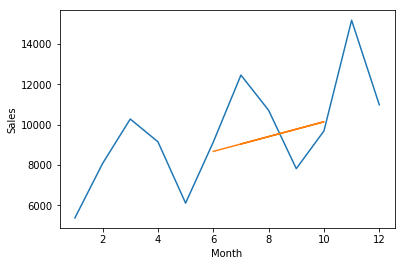

In [118]:
# Applying Linear Regression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from random import randint
import pandas as pd

# Predicting for next
sales_x_train, sales_x_test, sales_y_train, sales_y_test = train_test_split(sales_x, 
                                                                            sales_y, 
                                                                            test_size = 0.2, 
                                                                            random_state=randint(0,100))

regr = linear_model.LinearRegression()
regr.fit(x_2.values.reshape(-1,1), y_2.values.reshape(-1,1))
sales_y_pred = regr.predict(sales_x_test)

plt.plot(sales_x, sales_y)
plt.plot(sales_x_test, sales_y_pred)
plt.xlabel("Month")
plt.ylabel("Sales")
plt.show()

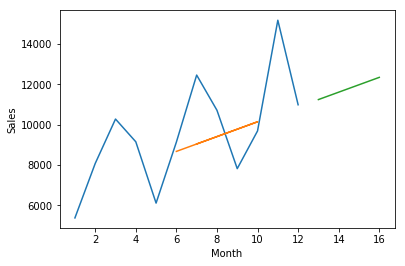

In [119]:
# Predicting for months 13, 14, 15 and 16
sales_x_forecast = pd.Series([13, 14, 15, 16]).values.reshape(-1,1)
sales_y_forecast = regr.predict(sales_x_forecast)

plt.plot(sales_x, sales_y)
plt.plot(sales_x_test, sales_y_pred)
plt.plot(sales_x_forecast, sales_y_forecast)
plt.xlabel("Month")
plt.ylabel("Sales")
plt.show()

In [120]:
print("Predictions for months 13, 14, 15 and 16 respectively: " + str(sales_y_forecast))

Predictions for months 13, 14, 15 and 16 respectively: [[11246.77376033]
 [11613.57644628]
 [11980.37913223]
 [12347.18181818]]


## 3. Prediction with seasonality

In [121]:
# Compute seasonal indices




for i in range(0, 3):
    for j in range(0, 4):
        
        print(((i*4)+j+1))

1
2
3
4
5
6
7
8
9
10
11
12
